In [7]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import numpy as np

class GPT2EarlyExitClassifier(torch.nn.Module):
    def __init__(self, model_name, exit_layers, threshold, verbalizers):
        super().__init__()

        self.model = AutoModelForCausalLM.from_pretrained(
            model_name,
            output_hidden_states=True
        )
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        self.exit_layers = exit_layers            # e.g. [2,4,6,8] or [3,6,9]
        self.threshold = threshold
        self.verbalizers = verbalizers            # {dataset: {class: [words]}}
        self.num_layers = len(self.model.transformer.h)

        # Precompute token IDs for verbalizers
        self.verbalizer_token_ids = {}
        for dataset, class_map in verbalizers.items():
            ids = {}
            for cls, words in class_map.items():
                tok_lists = []
                for w in words:
                    tok_lists.append(self.tokenizer.encode(" " + w))
                ids[cls] = tok_lists
            self.verbalizer_token_ids[dataset] = ids

    def build_prompt(self, text, dataset_name):
        if dataset_name == "sst2":
            return (
                f"Text: {text}\n\n"
                "Question: To which category does the text belong?\n"
                "Options: \"Positive Sentiment\", \"Negative Sentiment\"\n\n"
                "Answer:"
            )
    
        if dataset_name == "agnews":
            return (
                f"News Article: {text}\n\n"
                "Question: What is the topic of this article?\n"
                "Options: \"World\", \"Sports\", \"Business\", \"Technology\"\n\n"
                "Answer:"
            )
    
        return text

    @torch.no_grad()
    def classify(self, text, dataset_name):
        # Insert prompt
        #prompt = self.build_prompt(text, dataset_name)
        inputs = self.tokenizer(text, return_tensors="pt")
        input_ids = inputs["input_ids"]
    
        outputs = self.model(input_ids, output_hidden_states=True)
        hidden_states = outputs.hidden_states

        class_verbalizers = self.verbalizer_token_ids[dataset_name]

        # ----------------------------------------
        # EARLY EXIT AT SPECIFIED INTERMEDIATE LAYERS
        # ----------------------------------------
        for layer_idx in self.exit_layers:

            h = hidden_states[layer_idx][:, -1, :]
            logits = self.model.lm_head(h)[0]

            # Compute verbalizer class scores
            class_scores = []
            for cls, tok_lists in class_verbalizers.items():
                v_scores = []
                for tok_list in tok_lists:
                    idx = torch.tensor(tok_list, dtype=torch.long)
                    v_scores.append(logits[idx].mean().item())
                #class_scores.append(max(v_scores))
                class_scores.append(float(np.mean(v_scores)))

            class_scores = torch.tensor(class_scores)
            class_probs = torch.softmax(class_scores, dim=-1)

            pred = int(torch.argmax(class_probs))
            conf = float(class_probs[pred])

            if conf >= self.threshold:
                return pred, layer_idx, conf   # EARLY EXIT SUCCESS

        # ----------------------------------------
        # FINAL LAYER EXIT (LAYER 12)
        # ALWAYS EXECUTED, NO MATTER WHAT
        # ----------------------------------------
        final_layer = self.num_layers  # typically 12

        h = hidden_states[final_layer][:, -1, :]
        logits = self.model.lm_head(h)[0]

        class_scores = []
        for cls, tok_lists in class_verbalizers.items():
            v_scores = []
            for tok_list in tok_lists:
                idx = torch.tensor(tok_list, dtype=torch.long)
                v_scores.append(logits[idx].mean().item())
            #class_scores.append(max(v_scores))
            class_scores.append(float(np.mean(v_scores)))

        class_scores = torch.tensor(class_scores)
        class_probs = torch.softmax(class_scores, dim=-1)

        pred = int(torch.argmax(class_probs))
        conf = float(class_probs[pred])

        # FINAL EXIT — threshold ignored
        return pred, final_layer, conf

In [8]:
# ---------------------------------------
# BASELINE classifier (FINAL LAYER ONLY)
# ---------------------------------------
class GPT2BaselineClassifier(torch.nn.Module):
    def __init__(self, model_name, verbalizers):
        super().__init__()
        self.model = AutoModelForCausalLM.from_pretrained(
            model_name, output_hidden_states=True
        )
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.verbalizers = verbalizers
        self.num_layers = len(self.model.transformer.h)

        # Precompute tokens
        self.verbalizer_token_ids = {}
        for dataset, class_map in verbalizers.items():
            ids = {}
            for cls, words in class_map.items():
                tok_list = self.tokenizer.encode(" " + words[0])
                ids[cls] = tok_list
            self.verbalizer_token_ids[dataset] = ids

    @torch.no_grad()
    def classify(self, text, dataset_name):
        inputs = self.tokenizer(text, return_tensors="pt")
        input_ids = inputs["input_ids"]

        outputs = self.model(input_ids, output_hidden_states=True)
        hidden = outputs.hidden_states[self.num_layers][:, -1, :]

        logits = self.model.lm_head(hidden)[0]

        class_verbalizers = self.verbalizer_token_ids[dataset_name]
        scores = []

        for cls, tok_list in class_verbalizers.items():
            idx = torch.tensor(tok_list, dtype=torch.long)
            scores.append(logits[idx].mean().item())

        scores = torch.tensor(scores)
        probs = torch.softmax(scores, dim=-1)

        pred = int(torch.argmax(probs))
        return pred, self.num_layers, float(probs[pred])

In [9]:
verbalizers = {
    "sst2": {
        0: ["negative"],
        1: ["positive"]
    },
    "agnews": {
        0: ["international", "world", "global"],
        1: ["sports", "sport"],
        2: ["business", "finance", "market"],
        3: ["technology", "tech"]
    }
}

model = GPT2EarlyExitClassifier(
    model_name="gpt2",
    exit_layers=[2,4,6,8,10,12],
    threshold=0.8,
    verbalizers=verbalizers
)

pred, layer_used, conf = model.classify("This movie was great!", dataset_name="sst2")
print(pred, layer_used, conf)

1 2 0.9547190070152283


In [10]:
import time
import numpy as np

from evaluation.dataset_loaders.sst2 import load_sst2
from evaluation.dataset_loaders.agnews import load_agnews


# ---------------------------------------
# Verbalyzers for GPT-2 classification
# ---------------------------------------
verbalizers = {
    "sst2": {
        0: ["negative"],
        1: ["positive"],
    },
    "agnews": {
        0: ["international", "world", "global"],
        1: ["sports", "sport"],
        2: ["business", "finance", "market"],
        3: ["technology", "tech", "computer"],
    }
}

# ---------------------------------------
# Load datasets once
# ---------------------------------------
dataset_loaders = [
    ("sst2", load_sst2, "classification"),
    ("agnews", load_agnews, "classification"),
]

cached_datasets = {}
print("Loading datasets once...\n")

for name, loader, task in dataset_loaders:
    print(f"Loading {name}...")
    cached_datasets[name] = {
        "data": loader(number=500),
        "task": task
    }

print("\nAll datasets loaded.\n")


# ---------------------------------------
# Extract (text, label) from any format
# ---------------------------------------
def extract_text_label(sample):
    if isinstance(sample, dict):
        if "text" in sample:
            return sample["text"], sample["label"]
        elif "sentence" in sample:
            return sample["sentence"], sample["label"]
        elif "input_text" in sample:
            return sample["input_text"], sample["label"]
        else:
            raise ValueError("Unknown dict format:", sample)

    if isinstance(sample, (tuple, list)):
        return sample[0], sample[1]

    raise ValueError("Unknown sample format:", sample)


# ---------------------------------------
# Evaluation
# ---------------------------------------
def evaluate_dataset(model, dataset, dataset_name):
    correct = 0
    total = 0
    layers_used = []
    total_tokens = 0

    start = time.time()

    for sample in dataset:
        text, label = extract_text_label(sample)

        pred, layer, conf = model.classify(text, dataset_name)

        correct += (pred == label)
        total += 1
        layers_used.append(layer)

        total_tokens += len(model.tokenizer(text)["input_ids"])

    end = time.time()
    latency = (end - start) / total

    return {
        "metric": "accuracy",
        "score": correct / total,
        "avg_latency_sec": latency,
        "tokens_per_sec": total_tokens / (end - start),
        "avg_layers_used": float(np.mean(layers_used)),
        "num_samples": total
    }


# ---------------------------------------
# Run baseline + early exit
# ---------------------------------------
results_table = []

# -------------------------
# BASELINE FIRST
# -------------------------
print("\n==============================")
print("Running BASELINE")
print("==============================")

baseline_model = GPT2BaselineClassifier(
    model_name="gpt2",
    verbalizers=verbalizers
)

for name, meta in cached_datasets.items():
    dataset = meta["data"]
    print(f"\nTesting BASELINE on {name}...")

    result = evaluate_dataset(baseline_model, dataset, name)
    print(name, result)

    results_table.append({
        "dataset": name,
        "threshold": None,
        "mode": "baseline",
        "metric": result["metric"],
        "score": float(result["score"]),
        "avg_latency_sec": float(result["avg_latency_sec"]),
        "tokens_per_sec": float(result["tokens_per_sec"]),
        "avg_layers_used": float(result["avg_layers_used"]),
        "num_samples": int(result["num_samples"]),
    })


# -------------------------
# EARLY EXIT NEXT
# -------------------------
thresholds = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
exit_layers = [2, 4, 6, 8, 10, 12]   # important: include 12

for th in thresholds:
    print(f"\n==============================")
    print(f"Running threshold {th}")
    print("==============================")

    model = GPT2EarlyExitClassifier(
        model_name="gpt2",
        exit_layers=exit_layers,
        threshold=th,
        verbalizers=verbalizers
    )

    for name, meta in cached_datasets.items():
        dataset = meta["data"]

        print(f"\nTesting {name} (early_exit threshold={th})...")

        result = evaluate_dataset(model, dataset, name)
        print(name, result)

        results_table.append({
            "dataset": name,
            "threshold": th,
            "mode": "early_exit",
            "metric": result["metric"],
            "score": float(result["score"]),
            "avg_latency_sec": float(result["avg_latency_sec"]),
            "tokens_per_sec": float(result["tokens_per_sec"]),
            "avg_layers_used": float(result["avg_layers_used"]),
            "num_samples": int(result["num_samples"]),
        })

Loading datasets once...

Loading sst2...
Loading agnews...

All datasets loaded.


Running BASELINE

Testing BASELINE on sst2...
sst2 {'metric': 'accuracy', 'score': 0.582, 'avg_latency_sec': 0.02180881404876709, 'tokens_per_sec': 1080.9391077976888, 'avg_layers_used': 12.0, 'num_samples': 500}

Testing BASELINE on agnews...
agnews {'metric': 'accuracy', 'score': 0.564, 'avg_latency_sec': 0.03061607551574707, 'tokens_per_sec': 1686.8262548358762, 'avg_layers_used': 12.0, 'num_samples': 500}

Running threshold 0.5

Testing sst2 (early_exit threshold=0.5)...
sst2 {'metric': 'accuracy', 'score': 0.51, 'avg_latency_sec': 0.021350680351257326, 'tokens_per_sec': 1104.1334333222662, 'avg_layers_used': 2.0, 'num_samples': 500}

Testing agnews (early_exit threshold=0.5)...
agnews {'metric': 'accuracy', 'score': 0.304, 'avg_latency_sec': 0.03022504186630249, 'tokens_per_sec': 1708.6494115853395, 'avg_layers_used': 2.012, 'num_samples': 500}

Running threshold 0.6

Testing sst2 (early_exit thres

In [11]:
import pandas as pd
df=pd.DataFrame(results_table)
df

,dataset,threshold,mode,metric,score,avg_latency_sec,tokens_per_sec,avg_layers_used,num_samples
0,sst2,NaN,baseline,accuracy,0.582,0.021809,1080.939108,12.000,500
1,agnews,NaN,baseline,accuracy,0.564,0.030616,1686.826255,12.000,500
2,sst2,0.5,early_exit,accuracy,0.510,0.021351,1104.133433,2.000,500
3,agnews,0.5,early_exit,accuracy,0.304,0.030225,1708.649412,2.012,500
4,sst2,0.6,early_exit,accuracy,0.522,0.022519,1046.827579,2.132,500
5,agnews,0.6,early_exit,accuracy,0.322,0.031626,1632.943066,2.164,500
6,sst2,0.7,early_exit,accuracy,0.556,0.024854,948.504509,3.144,500
7,agnews,0.7,early_exit,accuracy,0.322,0.035341,1461.288271,2.436,500
8,sst2,0.8,early_exit,accuracy,0.614,0.029608,796.211633,6.156,500
9,agnews,0.8,early_exit,accuracy,0.328,0.036445,1417.021903,3.176,500


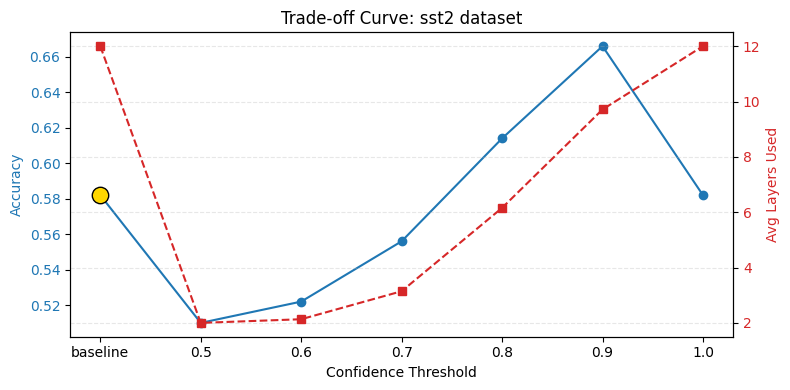

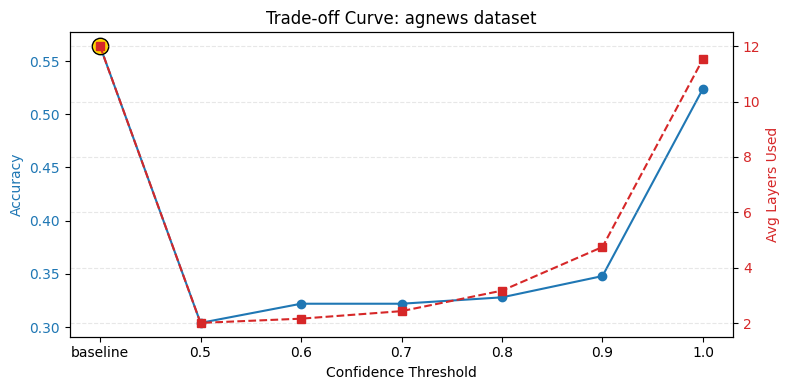

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import math

grouped = {}

# Build structured dataset including baseline
for row in results_table:
    ds = row["dataset"]
    if ds not in grouped:
        grouped[ds] = {
            "thresholds": [],
            "scores": [],
            "avg_layers": [],
            "mode": [],
        }

    th = row["threshold"]

    # Replace baseline's NaN with the string "baseline"
    if th is None or (isinstance(th, float) and math.isnan(th)):
        th = "baseline"

    grouped[ds]["thresholds"].append(th)
    grouped[ds]["scores"].append(row["score"])
    grouped[ds]["avg_layers"].append(row["avg_layers_used"])
    grouped[ds]["mode"].append(row["mode"])


# Plot for each dataset
for ds, data in grouped.items():

    thresholds = data["thresholds"]
    scores     = data["scores"]
    layers     = data["avg_layers"]
    modes      = data["mode"]

    # ---- Sort so "baseline" appears first ----
    # baseline = string, others = floats → custom sort key
    def sort_key(x):
        return -1 if x == "baseline" else float(x)

    sorted_idx = sorted(range(len(thresholds)), key=lambda i: sort_key(thresholds[i]))

    thresholds = [thresholds[i] for i in sorted_idx]
    scores     = [scores[i] for i in sorted_idx]
    layers     = [layers[i] for i in sorted_idx]
    modes      = [modes[i] for i in sorted_idx]

    # ---- Categorical x-axis ----
    x_labels = thresholds
    x_pos    = np.arange(len(x_labels))

    fig, ax1 = plt.subplots(figsize=(8, 4))

    # Accuracy curve
    ax1.set_xlabel("Confidence Threshold")
    ax1.set_ylabel("Accuracy", color="tab:blue")
    ax1.plot(x_pos, scores, marker="o", color="tab:blue", label="Accuracy")
    ax1.tick_params(axis="y", labelcolor="tab:blue")

    # Highlight baseline point
    for i, m in enumerate(modes):
        if m == "baseline":
            ax1.scatter(x_pos[i], scores[i], color="gold", s=140,
                        edgecolor="black", zorder=5, label="Baseline")

    # Layers curve (right axis)
    ax2 = ax1.twinx()
    ax2.set_ylabel("Avg Layers Used", color="tab:red")
    ax2.plot(x_pos, layers, marker="s", linestyle="--",
             color="tab:red", label="Layers Used")
    ax2.tick_params(axis="y", labelcolor="tab:red")

    # Put the baseline / threshold labels on x-axis
    plt.xticks(x_pos, x_labels)

    plt.title(f"Trade-off Curve: {ds} dataset")
    plt.grid(True, linestyle="--", alpha=0.3)
    plt.tight_layout()
    plt.show()